In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
from pathlib import Path

In [8]:
import sys
mod_to_reload = [
    mod for mod in sys.modules.keys() if mod.startswith("llm.")
]
for mod in mod_to_reload:
    sys.modules.pop(mod)

from llm.data import load_dataset, text_to_tensor, tensor_to_text
from llm.training import TrainingConfig, training_loop
# from llm.rnn import CharRNN
from llm.lstm import CharLSTM

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cpu = torch.device('cpu')

In [10]:
(train_dataset, valid_dataset), ctoi, itoc = load_dataset(
    Path("dataset", "lotr.txt"), slice(0, 2_000_000), slice(2_000_000, None)
)

print(f"Train dataset length:      {len(train_dataset)} characters")
print(f"Validation dataset length: {len(valid_dataset)} characters")

Train dataset length:      2000000 characters
Validation dataset length: 579949 characters


In [11]:
# model = CharRNN(vocab_size=len(ctoi), embedding_dim=16, hidden_dim=64, num_layers=1)
model = CharLSTM(vocab_size=len(ctoi), embedding_dim=16, hidden_dim=64, num_layers=2)

print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

CharLSTM(
  (embedding): Embedding(96, 16)
  (lstm): LSTM(16, 64, num_layers=2)
  (linear): Linear(in_features=64, out_features=96, bias=True)
)
Number of parameters: 62048


In [12]:
config = TrainingConfig(
    device,
    n_epochs=800,
    seq_len=128,
    batch_size=16,
    lr=0.001,
    lr_sched_factor=0.8,
    lr_sched_patience=25,
)

model.to(device)
t0 = time.perf_counter()
train_losses, valid_losses, learning_rates = training_loop(
    model, config, train_dataset, valid_dataset
)
t1 = time.perf_counter()
print(f"Training time: {t1-t0:.0f} seconds")

Training loop configuration: TrainingConfig(device=device(type='cuda'), n_epochs=800, seq_len=128, batch_size=16, lr=0.001, lr_sched_factor=0.8, lr_sched_patience=25)
epoch     0/799: train loss = 0.159188, valid loss = 0.130624, learning rate = 0.001
epoch   100/799: train loss = 0.076296, valid loss = 0.081162, learning rate = 0.001
epoch   200/799: train loss = 0.074238, valid loss = 0.080210, learning rate = 0.0008
epoch   300/799: train loss = 0.073266, valid loss = 0.079577, learning rate = 0.0004096000000000001
epoch   400/799: train loss = 0.072839, valid loss = 0.079436, learning rate = 0.0002621440000000001
epoch   500/799: train loss = 0.072588, valid loss = 0.079382, learning rate = 0.0001677721600000001
epoch   600/799: train loss = 0.072424, valid loss = 0.079343, learning rate = 8.589934592000007e-05
epoch   700/799: train loss = 0.072338, valid loss = 0.079308, learning rate = 5.497558138880005e-05
epoch   799/799: train loss = 0.072273, valid loss = 0.079264, learning 

In [13]:
def display_training_review(train_losses, valid_losses=None, learning_rates=None):
    fig, ax = plt.subplots()

    ax.set_title("Cross entropy over the epochs")
    ax.plot(train_losses, label="train loss")
    if valid_losses is not None:
        ax.plot(valid_losses, label="valid loss")
        best_valid_epoch = np.argmin(valid_losses)
        best_valid = valid_losses[best_valid_epoch]
        ax.plot(best_valid_epoch, best_valid, 'or')
        ax.text(best_valid_epoch, best_valid, f"({best_valid_epoch}, {best_valid:.6f})", ha='center', va='top', color='red')
    ax.legend(loc='upper right')
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.grid()

    if learning_rates is not None:
        lr_ax = ax.twinx()
        lr_ax.plot(learning_rates, ':r', label='learning rate')
        lr_ax.set_xlabel("epoch")
        lr_ax.set_ylabel("learning rate")
        lr_ax.legend(loc='lower left')

    fig.tight_layout()
    plt.show()


def print_prediction_examples(model, test_contexts, n_predictions=80, repeat=4):
    model.eval()

    with torch.no_grad():
        print("Deterministic predictions:")
        for context in test_contexts:
            context_tokens = text_to_tensor(context, ctoi)
            predicted_tokens = model.predict_argmax(context_tokens, n_predictions)
            predicted_text = tensor_to_text(predicted_tokens, itoc)
            print(f"{repr(context)} -> {repr(predicted_text)}")

        print("\nProbabilistic predictions:")
        for context in test_contexts:
            for _ in range(repeat):
                predicted_tokens = model.predict_proba(context_tokens, n_predictions)
                predicted_text = tensor_to_text(predicted_tokens, itoc)
                print(f"{repr(context)} -> {repr(predicted_text)}")


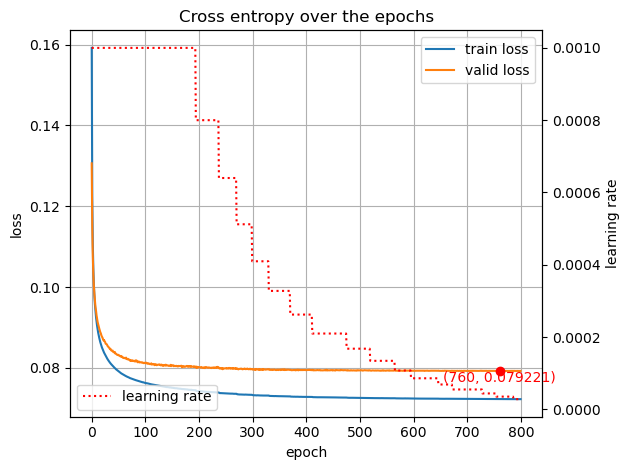

In [14]:
model.to(cpu)
display_training_review(train_losses, valid_losses, learning_rates)

In [26]:
test_contexts = (
    "The throne",
    "Aragorn son of",
    "He paused, ",
    "the ring of ",
    "suddenly",
    "you cannot ",
    "I am a servant of the Secret Fire",
)
print_prediction_examples(model, test_contexts, 80)

Deterministic predictions:
'The throne' -> ' the Ring of the Shire and the stream that the way that was the stream that they'
'Aragorn son of' -> ' the Shire and the stream and the stream and the stream of the stones and the st'
'He paused, ' -> 'ever if the stream that he was a strange stars and strange of the stones and the'
'the ring of ' -> 'the water and the stream that he was still the stream of the stones and the stre'
'suddenly' -> ' Shadowfax and the stream of the stones and the stream of the stones and the str'
'you cannot ' -> 'the stream that they were still the stream and the stream of the stones and the '
'I am a servant of the Secret Fire' -> ' and the stream and the stream of the stones and the stream of the stones and th'

Probabilistic predictions:
'The throne' -> 's, and his own broken bur by dark lower horled. Do any holided; southitor, the m'
'The throne' -> 's each behind. At last he searching sunlight, saw him or not be grow, at wearine'
'The throne' -> ', scouch